<a href="https://colab.research.google.com/github/Chaelsy-kim/Capstone_Design/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

mtest_path = '/content/drive/MyDrive/dah/test/metal/'
wtest_path = '/content/drive/MyDrive/dah/test/wood/'
mtrain_path = '/content/drive/MyDrive/dah/train/metal/'
wtrain_path = '/content/drive/MyDrive/dah/train/wood/'
mvalid_path = '/content/drive/MyDrive/dah/valid/metal/'
wvalid_path = '/content/drive/MyDrive/dah/valid/wood/'

In [ ]:
class ImageTransform() : 
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    #transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                # scale=(0.5, 1.0) : 랜덤 크기 50~100% 리사이징
                    #transforms.RandomHorizontalFlip(), # 수평 반전
                    transforms.ToTensor(), # (H, W, C) --> (C, H, W)
                    #transforms.Normalize(mean ,std) # 정규화
                # mean (0.485, 0.456, 0.406), std (0.229, 0.224, 0.225)
                # ---> ImageNet의 이미지 RGB 채널마다 평균과 표준편차를 의미
            ]),
            'val' : transforms.Compose([
                    #transforms.Resize(256),
                    #transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    #transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [ ]:
mtest_file = sorted([os.path.join(mtest_path, f) for f in os.listdir(mtest_path)])
wtest_file = sorted([os.path.join(wtest_path, f) for f in os.listdir(wtest_path)])

mtrain_file = sorted([os.path.join(mtrain_path, f) for f in os.listdir(mtrain_path)])
wtrain_file = sorted([os.path.join(wtrain_path, f) for f in os.listdir(wtrain_path)])

mvalid_file = sorted([os.path.join(mvalid_path, f) for f in os.listdir(mvalid_path)])
wvalid_file = sorted([os.path.join(wvalid_path, f) for f in os.listdir(wvalid_path)])

filepath1 = [*wtest_file, *mtest_file]
filepath2 = [*wtrain_file, *mtrain_file]
filepath3 = [*wvalid_file, *mvalid_file]

test_image = [i for i in filepath1 if cv2.imread(i) is not None]
train_image = [i for i in filepath2 if cv2.imread(i) is not None]
valid_image = [i for i in filepath3 if cv2.imread(i) is not None]

random.seed(10)
print(len(test_image),len(train_image),len(valid_image))
#random.shuffle(test_file)
#random.shuffle(train_file)
#random.shuffle(valid_file)

20 1050 90


In [ ]:
def display_img_grid(img_filepath, pred_labels=(), cols=5) :
    rows = len(img_filepath) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_filepath in enumerate(img_filepath) :
        image = cv2.imread(img_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(img_filepath).split(os.sep)[-2]
        pred_label = pred_labels[i] if pred_labels else true_label
        color = 'green' if true_label == pred_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

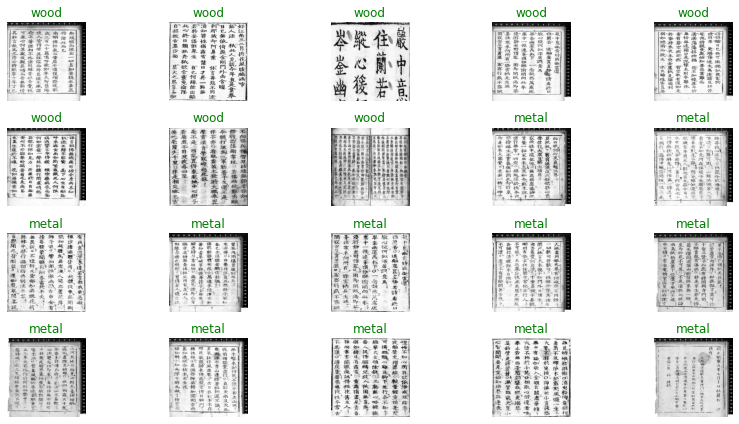

In [ ]:
display_img_grid(test_image)

In [ ]:
class mwdataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-2].split('.')[0]
        if label == 'metal' :
            label = 0
        elif label == 'wood' :
            label = 1
        return img_transformed, label

In [ ]:
batch_size = 16
train_dataset = mwdataset(train_image, transform = ImageTransform(0,0,0), phase = 'train')
valid_dataset = mwdataset(valid_image, transform = ImageTransform(0,0,0), phase = 'val')

print(train_dataset.__getitem__(0)[0].size())

torch.Size([3, 640, 640])


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train':train_dataloader, 'val':valid_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([16, 3, 640, 640])
tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1])


In [ ]:
class LeNet(nn.Module) :
    def __init__(self) :
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, 
                             kernel_size=5, stride=1, padding=0) # (16, 636, 636)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (16, 318, 318)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,
                             stride=1, padding=0) # (32, 314, 314)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # (32, 157, 157)
        
        self.fc1 = nn.Linear(32*157*157, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x) :
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [ ]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=788768, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 640,640))

RuntimeError: ignored

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train_model(model, dataloader_dict, criterion, optimizer, n_epochs) :
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(n_epochs) : 
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()
                
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # 기욹 ㅣ초기화
                
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                    
                    # 손실 함수는 오차를 배치크기로 나누어 평균을 반환하므로, 
                    # epoch_loss 계산 시 loss.item()과 inputs.size()를 곱하여 줌
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
                print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
                    

                if phase == 'val' and epoch_acc > best_acc :
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                        
        time_elapsed = time.time() - since
        print(f'Training complete in : {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val acc : {best_acc:4f}')
        
        return model

In [ ]:
import time

n_epochs = 10
model = train_model(model, dataloader_dict, criterion, optimizer, 13)

Epoch 1/13
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/66 [00:00<?, ?it/s]

train Loss : 0.0133 Acc : 0.0067
train Loss : 0.0134 Acc : 0.0133
train Loss : 0.0162 Acc : 0.0171
train Loss : 0.0143 Acc : 0.0229
train Loss : 0.0124 Acc : 0.0305
train Loss : 0.0143 Acc : 0.0362
train Loss : 0.0105 Acc : 0.0457
train Loss : 0.0095 Acc : 0.0562
train Loss : 0.0114 Acc : 0.0648
train Loss : 0.0153 Acc : 0.0695
train Loss : 0.0162 Acc : 0.0733
train Loss : 0.0115 Acc : 0.0819
train Loss : 0.0105 Acc : 0.0914
train Loss : 0.0124 Acc : 0.0990
train Loss : 0.0134 Acc : 0.1057
train Loss : 0.0124 Acc : 0.1133
train Loss : 0.0115 Acc : 0.1219
train Loss : 0.0115 Acc : 0.1305
train Loss : 0.0143 Acc : 0.1362
train Loss : 0.0105 Acc : 0.1457
train Loss : 0.0134 Acc : 0.1524
train Loss : 0.0115 Acc : 0.1610
train Loss : 0.0143 Acc : 0.1667
train Loss : 0.0086 Acc : 0.1781
train Loss : 0.0105 Acc : 0.1876
train Loss : 0.0115 Acc : 0.1962
train Loss : 0.0134 Acc : 0.2029
train Loss : 0.0143 Acc : 0.2086
train Loss : 0.0105 Acc : 0.2181
train Loss : 0.0143 Acc : 0.2238
train Loss

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss : 0.2335 Acc : 0.0000
val Loss : 0.2361 Acc : 0.0000
val Loss : 0.2361 Acc : 0.0000
val Loss : 0.0805 Acc : 0.1556
val Loss : 0.0566 Acc : 0.3333
val Loss : 0.0354 Acc : 0.4444
Training complete in : 0m 39s
Best val acc : 0.444444
